In [29]:
import numpy as np
import h5py
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Optimization module in scipy
from scipy import optimize
import utils

In [30]:
def load_data(path):
    # Load .mat file
    mat = scipy.io.loadmat(path)
    # Access variables in the .mat file
    X = mat['X']
    
    y = mat['y'].ravel()
    y[y == 10] = 0
    
    return X, y


X, y = load_data("data/data_number.mat")

In [31]:
print('X:',X.shape)
print('y:',y.shape)

X: (5000, 400)
y: (5000,)


## I. Data Description

There are 5000 training examples in `data_number.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix $X$. This gives us a 5000 by 400 matrix $X$ where every row is a training example for a handwritten digit image.
$$ X = \begin{bmatrix} - \left(x^{(1)} \right)^T - \\ - \left(x^{(2)} \right)^T - \\ \vdots \\ - \left(x^{(m)} \right)^T - \\ \end{bmatrix} $$


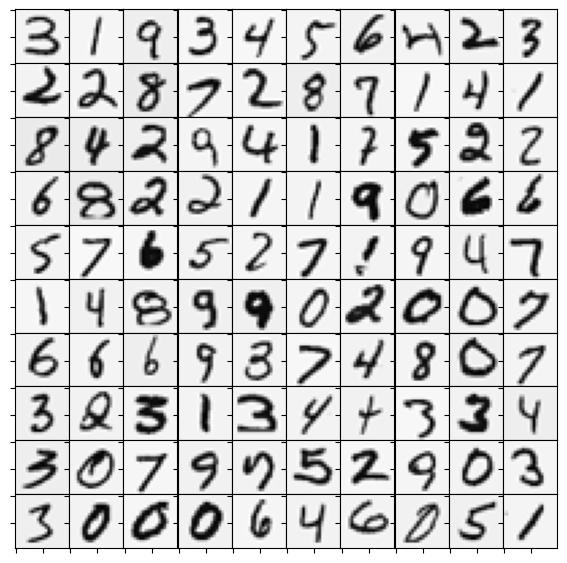

In [32]:
def displayData(X, nrows, ncols):
    # set up array
    fig, axarr = plt.subplots(nrows = nrows, ncols = ncols, figsize = (7, 7))
    
    for i in range(nrows):
        for j in range(ncols):
            ind = np.random.randint(X.shape[0])
            tmp = X[ind,:].reshape(20, 20, order = 'F')
            axarr[i,j].imshow(tmp, cmap = 'gray_r')
            plt.setp(axarr[i,j].get_xticklabels(), visible = False)
            plt.setp(axarr[i,j].get_yticklabels(), visible = False)
    
    fig.subplots_adjust(hspace = 0, wspace = 0)
    
displayData(X, 10, 10)

## II. Model Representation

It has 3 layers - an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size $20 \times 20$, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1). The training data was loaded into the variables X and y above.

- Input layer size = 400 (20 x 20 pixels) <br>
- Hidden layer size = 25<br>
- Number of labels or output layers = 10<br>

![caption](neural_network_diagram.jpg)

## III. Build Neural Network

In [46]:
def sigmoidGradient(z):
    g = np.zeros(z.shape)
    g = sigmoid(z) * (1 - sigmoid(z))
    return g

def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return(g)

In [47]:
def randInitializeWeights(L_in, L_out):
    epsilon_int = 0.12
    eps_rand = np.random.rand(L_out, 1 +  L_in) * 2 * epsilon_int - epsilon_int
    
    return(eps_rand)

In [48]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_=0.0):
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
 
    Returns
    -------
    J : float
        The computed value for the cost function at the current weight values.
    
    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
    ------------
   
    """
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    # Setup some useful variables
    m = y.size
         
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    a2 = sigmoid(a1.dot(Theta1.T))
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)
    
    a3 = sigmoid(a2.dot(Theta2.T))
    
    y_matrix = y.reshape(-1)
    y_matrix = np.eye(num_labels)[y_matrix]
    
    temp1 = Theta1
    temp2 = Theta2
    
    # Add regularization term
    reg_term = (lambda_ / (2 * m)) * (np.sum(np.square(temp1[:, 1:])) + np.sum(np.square(temp2[:, 1:])))
    
    J = (-1 / m) * np.sum((np.log(a3) * y_matrix) + np.log(1 - a3) * (1 - y_matrix)) + reg_term
    
    # Backpropogation
    delta_3 = a3 - y_matrix
    delta_2 = delta_3.dot(Theta2)[:, 1:] * sigmoidGradient(a1.dot(Theta1.T))

    Delta1 = delta_2.T.dot(a1)
    Delta2 = delta_3.T.dot(a2)
    
    # Add regularization to gradient

    Theta1_grad = (1 / m) * Delta1
    Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (lambda_ / m) * Theta1[:, 1:]
    
    Theta2_grad = (1 / m) * Delta2
    Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (lambda_ / m) * Theta2[:, 1:]

    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

    return J, grad

In [49]:
def predict(Theta1, Theta2, X):
    # sizes
    m, n = X.shape
    num_labels = Theta2.shape[0]
    
    # add ones to X data matrix
    X = np.hstack((np.ones((m, 1)), X))
        
    # hidden layer
    z2 = np.dot(X, Theta1.T)
    a2 = sigmoid(z2)

    #add bias unit to a2
    a2 = np.hstack((np.ones((a2.shape[0],1)), a2))

    # output layer
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)

    p = np.argmax(a3, axis=1)
    
    return p

####  Setup the parameters

In [50]:
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

In [51]:
print('Initializing Neural Network Parameters ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Initializing Neural Network Parameters ...


#### Neural Network

In [52]:
options= {'maxiter': 100}

lambda_ = 1

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)

res = optimize.minimize(costFunction, initial_nn_params, jac=True, method='TNC', options=options)

# get the solution of the optimization
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

#### Predict Model 

In [55]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))

Training Set Accuracy: 96.320000
